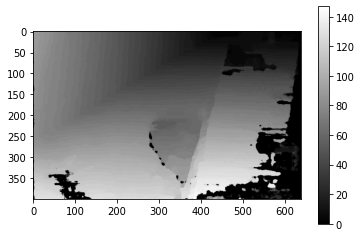

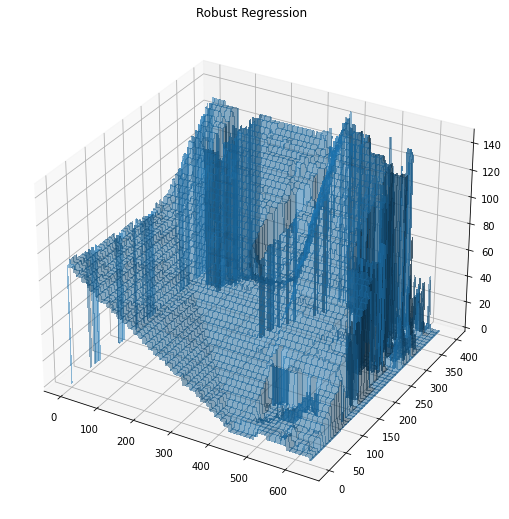

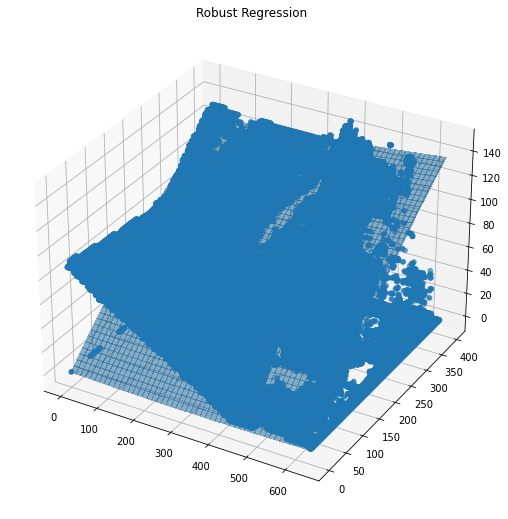

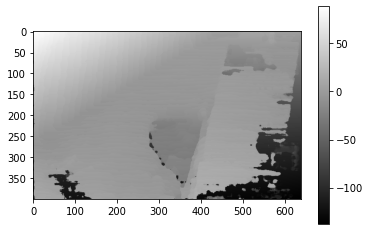

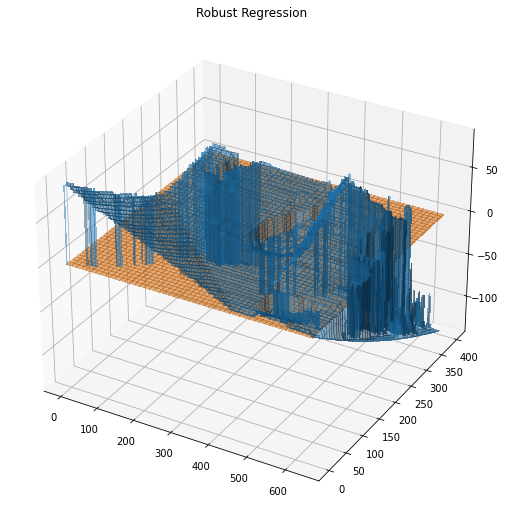

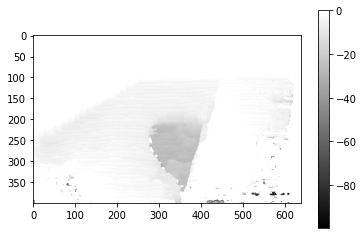

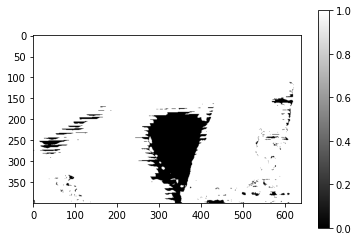

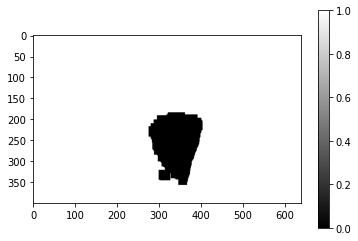

[51.0]


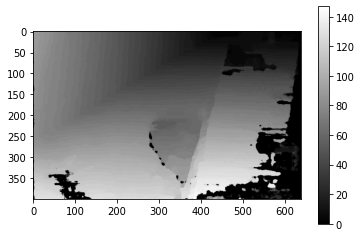

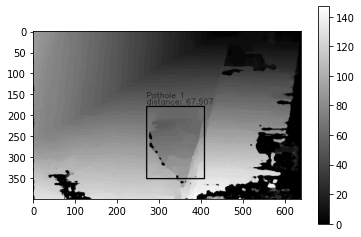

In [4]:
#importing necessary libraries
# import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits import mplot3d
from matplotlib import cm
import scipy.optimize
from scipy.stats import cauchy
# import statistics
# from sklearn.linear_model import HuberRegressor, LinearRegression
# from sklearn.datasets import make_regression
import math
# import glob
# import os

depth = np.load("image_0.npy") #loading the depth-map by generated from the camera
plt.imshow(depth, "gray")
plt.colorbar()
plt.show()
# cv2.imwrite(path + '/'+'image'+ str(p) + '.png',depth)# Save the depth image

depth3d = np.copy(depth) # save a copy of the depth map in a new variable
sum_dis = 0 # store the sum of all the depth values in a variable
disp_no =0 # store the total number of depth values
width = depth.shape[1] # store the width of depth image
height = depth.shape[0]# store the height of depth image

w=[]
h=[]
for i in range(height):
        for j in range(width):
            w.append(i)
            h.append(j)
w1 = np.reshape(w,(height,width))
h1 = np.reshape(h,(height,width))

# charting the surface plot of depth-map for better visualization 
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_title('Robust Regression')
ax.plot_surface(h1,w1 ,depth,linewidth=0, antialiased=False, shade = True, alpha = 0.5)
plt.show()

max_d = 190 # maximum disparity of Oak-D camera already known
min_d = (882.5 * 7.5) / 190 # Minimum disparity of Oak-D camera

# The input depth map being rectified itself and due to problems like occlusion,etc. contains many garbage values
# These garbage values misleads the surface fit form
# hence we assign a value such that its effect is minimised 
# Hence ,  we assign the average value
for i in range(depth.shape[0]):
    for j in range(depth.shape[1]):
        if depth[i][j]>=min_d and depth[i][j]<=max_d :
            sum_dis= sum_dis + depth[i][j]
            disp_no = disp_no + 1
avg_depth = sum_dis/disp_no
d1= depth.flatten()
for i in range(depth.shape[0]):
    for j in range(depth.shape[1]):
        if depth[i][j]<min_d or depth[i][j]>max_d :
            depth3d[i][j] = int(avg_depth)

#We seperate out the garbage values and do not consider it while calculating the surfface fit

depth1 = np.zeros((height,width))
w2 = []
h2 =[]
d2 =[]
for i in range(height):
        for j in range(width):
            if(depth3d[i][j] == int(avg_depth) and depth[i][j]!= int(avg_depth)):
                depth1[i][j]= depth3d[i][j]
            else:
                d2.append(depth3d[i][j])
                w2.append(i)
                h2.append(j)
# Surface fit equation: 
# z = a1 + a2x + a3y + a4x^2 + a5xy + a6y^2
# we calculate the residual of actual z value available from depth-map and that we get from this equation and minimize it to get the coefficients

def fun_residual(cf, vars, z):
    x, y = vars
    return (( cf[0] + cf[1]*x + cf[2]*y + cf[3]*x*x + cf[4]*y*x + cf[5]*y*y ) - z)**2

def fun_z(cf, x, y): # calculate the coefficients

    return cf[0] + cf[1]*x + cf[2]*y + cf[3]*x*x + cf[4]*y*x + cf[5]*y*y 

cf0 = np.zeros(6)

res_robust = scipy.optimize.least_squares(fun_residual, cf0, loss='cauchy', f_scale=100, args=((np.array(w2), np.array(h2)), np.array(d2)))

x1 = np.linspace(0, width, 32)

y1 = np.linspace(0, height, 32)

xv, yv = np.meshgrid(x1, y1)
cfs = res_robust.x
zv =fun_z(cfs, w1, h1)
z1 =zv.flatten()
# Plot the expected surface fit and the scatter plot for a comparitive study 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_title('Robust Regression')
ax.plot_surface(h1,w1,zv,linewidth=0, antialiased=False, shade = True, alpha = 0.5)
ax.scatter3D(h, w, d1)
plt.show()

#Calculate the difference of the two surfaces
diff =np.array(depth) - np.array(zv)
plt.imshow(diff, "gray")
plt.colorbar()
plt.show()
#plot this difference with a cap difference 0
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.set_title('Robust Regression')
ax.plot_surface(h1,w1 ,diff,linewidth=0, antialiased=False, shade = True, alpha = 0.5)
ax.plot_surface(h1,w1 ,np.zeros((height,width)),linewidth=0, antialiased=False, shade = True, alpha = 0.5)
plt.show()

# copy this difference in another variable
diff_2 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        diff_2[i][j] = diff[i][j]
# Region whose difference is greater than 0 are not pothole region hence we assign them 0
for i in range(height):
    for j in range(width):
        if diff_2[i][j] >0:
            diff_2[i][j] = 0

# now copy this difference in another variable
diff_4 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        diff_4[i][j] = diff_2[i][j]
# our pothole region must not correpond to a garbage value and hence assign them 0
for i in range(height):
    for j in range(width):
        if(depth[i][j]< min_d or depth[i][j]> max_d):
            diff_4[i][j] = 0
plt.imshow(diff_4, "gray")
plt.colorbar()
plt.show()

#Now we calculate the average of all the candidate pothole regions
sumc =0
noc = 0
for i in range(height):
    for j in range(width):
        sumc= sumc + diff_4[i][j]
        if(diff_4[i][j] != 0):
            noc = noc +1
avgc = sumc / noc

#We now create a binary image of the difference obtained with the threshold that all points below the average of all pothole candidates represent a pothole
diff_3 = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        diff_3[i][j] = diff_2[i][j]
for i in range(depth3d.shape[0]):
    for j in range(depth3d.shape[1]):
        if(diff_4[i][j] <= (avgc)):
            diff_3[i][j] =0 
        else:
            diff_3[i][j] =1
plt.imshow(diff_3 , 'gray')
plt.colorbar()
plt.show()


# Since the obtained binary image also has some noise we use image processing to minimize them 
kernel2 = np.ones((21, 21), np.uint8)
dst2 = cv2.dilate(diff_3, kernel2, iterations=1)
dst3 = cv2.erode(dst2, kernel2, iterations=1)
diff_5 = cv2.morphologyEx(dst3, cv2.MORPH_CLOSE, kernel2)
plt.imshow(diff_5 , 'gray')
plt.colorbar()
plt.show()

# We have successfully detected the potholes now and now wish to label them so that they are identified as seperate potholes
# We create a binary image with limits(0,255) so as to fit the labels
disparity_z = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        disparity_z[i][j] = depth[i][j]
for i in range(height):
    for j in range(width):
        if(diff_5[i][j] == 0):
            disparity_z[i][j] = 255

# We use connected component labelling algorithm here(Better explained in notes)
disparity_pl = np.zeros((height+1,width+1))
child=[]
mom =[]
a=50
for i in range(1,height):
    for j in range(1,width):
        if(disparity_z[i][j] == 255):
            if(disparity_pl[i-1][j]==0 and disparity_pl[i][j-1]==0 ):
                a = a+1
                disparity_pl[i][j]=a
            else:
                if(disparity_pl[i-1][j]!=0 or disparity_pl[i][j-1]!=0):
                    if(disparity_pl[i-1][j]==0 and disparity_pl[i][j-1]!=0):
                        disparity_pl[i][j]=disparity_pl[i][j-1]
                    elif(disparity_pl[i-1][j]!=0 and disparity_pl[i][j-1]==0):
                        disparity_pl[i][j]=disparity_pl[i-1][j]
                    elif(disparity_pl[i-1][j]!=0 and disparity_pl[i][j-1]!=0):
                        c = min(disparity_pl[i-1][j] , disparity_pl[i][j-1])
                        mo =c
                        disparity_pl[i][j] = c
                        chil = max(disparity_pl[i-1][j] , disparity_pl[i][j-1])
                        if mo in child:
                            mom.append(mom[child.index(mo)])
                        else:
                            mom.append(mo)
                        child.append(chil)
for i in range(1,height):
    for j in range(1,width):
        if(disparity_pl[i][j] in child):
            disparity_pl[i][j] = mom[child.index(disparity_pl[i][j])]

#Single contains parent value with duplication removed
single = [] 
[single.append(x) for x in mom if x not in single]
print(single)

# We draw a rectangle around these potholes and also display its distnce
disparity_rect = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        disparity_rect[i][j] = depth[i][j]
top=[]
bottom=[]
left =[]
right =[]
sum_calc = 0
d_no = 0
#Calculate left , right , top and bottom corner coordinates for rectangle around each pothole
for x in range(len(single)):
    proxy =[]
    proxy2=[]
    for i in range(0,height):
        for j in range(0,width):
            if(disparity_pl[i][j] == single[x]):
                proxy.append(i)
                break
    top.append(proxy[0])
    bottom.append(proxy[len(proxy)-1])
    for j in range(0,width):
        for i in range(0,height):
            if(disparity_pl[i][j] == single[x]):
                sum_calc = sum_calc + depth[i][j]
                d_no = d_no+1
    avg_disp = sum_calc / d_no 
    #Assumption: I encounter the particular label only in one pothole 
    for j in range(0,width):
        for i in range(0,height):
            if(disparity_pl[i][j] == single[x]):
                proxy2.append(j)
                break
    left.append(proxy2[0])
    right.append(proxy2[len(proxy2)-1])
a =1
for x in range(len(single)):
    start_point = (left[x]-5 , top[x]-5)
    end_point = (right[x]+5 , bottom[x]+5)
    start_point_txt = (left[x]-5 , top[x]-25)
    start_point_txt1 = (left[x]-5 , top[x]-10)
    color = (255, 0, 0)

    # Line thickness of 2 px
    thickness = 2
    txt = 'Pothole '+str(a)
    txt1 = 'depth: '+str(avg_disp)
    # Using cv2.rectangle() method
    # Draw a rectangle with thickness of 2 px
    disparity_rect = cv2.rectangle(disparity_rect, start_point, end_point, color, thickness)
    disparity_rect = cv2.putText(disparity_rect, txt , start_point_txt,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    disparity_rect = cv2.putText(disparity_rect, txt1 , start_point_txt1,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1)
    a=a+1
# Now to further eliminate a region which is not pothole but has been detected even after processing , we border out the image into a smaller frame
# all LABELLED potholes whose even a small part liews in these region are eliminated
single1 = []
remove = []
remove=[]
removel=[]
remover=[]
removet=[]
removeb=[]
[single1.append(x) for x in single]
avg =[]
avg_pot=[]
for x in range(len(single)):
    sum_final =0
    dis_final_no =0
    sum_final_pot =0
    dis_final_no_pot =0
    for s in range(top[x]-20, bottom[x]+20):
        for r in range(left[x]-20 , right[x]+20):
            if(s < 0 or s >= height or r<0 or r>=width):
                if single[x] not in remove:
                    remove.append(single[x])
                    removel.append(left[x])
                    remover.append(right[x])
                    removet.append(top[x])
                    removeb.append(bottom[x])
#                 print(single[x])
            else:
                if(disparity_pl[s][r] ==0 and depth[s][r] != 0):
                    sum_final = sum_final + depth[s][r]
                    dis_final_no = dis_final_no + 1
                else:
                    sum_final_pot = sum_final_pot + depth[s][r]
                    dis_final_no_pot = dis_final_no_pot + 1
    avg_dis_final = sum_final / dis_final_no
    avg.append(avg_dis_final)
    avg_dis_final_pot = sum_final_pot / dis_final_no_pot
    avg_pot.append(avg_dis_final_pot)
diff_pot =[]
for x in range(len(avg)):
    difflia = avg[x]-avg_pot[x]
    diff_pot.append(difflia)
for i in range(len(remove)):
    single1.remove(remove[i])
    left.remove(removel[i])
    right.remove(remover[i])
    top.remove(removet[i])
    bottom.remove(removeb[i])
disparity_rect_1 = np.copy(depth)
plt.imshow(disparity_rect_1 , 'gray')            
plt.colorbar()
plt.show()

# Finally we draw the rectangle with its depth
a =1
for x in range(len(single1)):
    start_point = (left[x]-5 , top[x]-5)
    end_point = (right[x]+5 , bottom[x]-5)
    start_point_txt = (left[x]-5 , top[x]-25)
    start_point_txt1 = (left[x]-5 , top[x]-10)
    color = (0, 0, 0)

    # Line thickness of 2 px
    thickness = 2
    txt = 'Pothole '+str(a)
    txt1 = 'distance: '+str(round(avg_pot[x],3))
    # Using cv2.rectangle() method
    # Draw a rectangle with blue line borders of thickness of 2 px
    disparity_rect_1 = cv2.rectangle(disparity_rect_1, start_point, end_point, color, thickness)
    disparity_rect_1 = cv2.putText(disparity_rect_1, txt , start_point_txt,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)
    disparity_rect_1 = cv2.putText(disparity_rect_1, txt1 , start_point_txt1,
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1)
    a=a+1
cv2.imshow('Pothole_Detected', disparity_rect_1)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(disparity_rect_1 , 'gray')            
plt.colorbar()
plt.show()
# Save the detected pothole image
# cv2.imwrite(path + '/'+'Pothole.png',disparity_rect_1)